In [1]:
import pandas as pd
import numpy as np

In [59]:
from copy import deepcopy

<h3>Read data</h3>

In [2]:
positions = pd.read_parquet('./../data/clean/positions.parquet')

In [3]:
positions.head()

,Дата,ID_SKU,Телефон_new,Цена,Количество,Группа2,Группа3,Группа4,Тип,ТипТовара
0,2017-07-01,IDL00051334048,55574948-52495050484877,50.0,1.0,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,МГТ
1,2017-07-01,IDL00051367351,55574948-52495050484877,50.0,1.0,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,МГТ
2,2017-07-01,IDL00007611755,55574948-52495050484877,49.0,1.0,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,МГТ
3,2017-07-01,IDL00014478250,55574948-52495050484877,40.0,1.0,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,МГТ
4,2017-07-01,IDL00001209351,55574948-52495050484877,169.0,1.0,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,колготки,ОДЕЖДА,МГТ


In [4]:
positions.shape

(937178, 10)

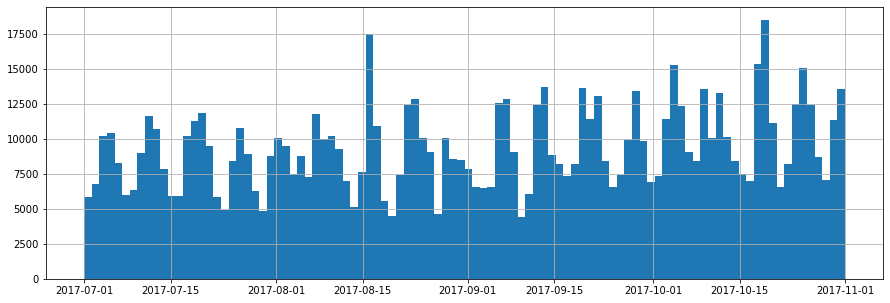

In [58]:
positions['Дата'].hist(figsize=(15,5), bins=100); # data for 3 months

<h3>Filter items / categories</h3>

<h4>Items</h4>

In [5]:
print('There are', positions['Телефон_new'].nunique(), 'users')

There are 130752 users


In [6]:
sku_freq = positions['ID_SKU'].value_counts()

print('There are', len(sku_freq), 'unique items; q99 for value counts:', np.quantile(sku_freq, 0.99))

There are 118386 unique items; q99 for value counts: 77.0


In [7]:
items_sku = sku_freq[sku_freq > 77].index.values; print(len(items_sku), 'items in q99')

1178 items in q99


<h4>Categories</h4>

In [8]:
print('There are', positions['Группа3'].nunique(), 'categories')

There are 96 categories


In [9]:
categ_sku = positions['Группа3'].value_counts() > 77
categ_sku = categ_sku[categ_sku].index.values

In [13]:
print('There are', len(categ_sku), 'categories with enough data')

There are 77 categories with enough data


<h4>Generate sequences</h4>

In [19]:
def get_sku(item, categ):
    if item in items_sku: # get item if known
        return item
    if categ in categ_sku: # get category if known
        return categ
    return 'None' # no idea what it is

In [20]:
%%time
new_col = positions.apply(lambda x: get_sku(x['ID_SKU'], x['Группа3']), axis=1)

CPU times: user 47.5 s, sys: 598 ms, total: 48.1 s
Wall time: 47.9 s


In [92]:
print('items:', new_col.apply(lambda x: x[:2] == 'ID').sum())
print('categ:', new_col.apply(lambda x: x[:2] != 'ID').sum())

items: 434082
categ: 503096


In [93]:
users = deepcopy(positions[['Телефон_new']])

In [94]:
users['items'] = new_col.astype(str)

In [95]:
sequences = users.groupby('Телефон_new')['items'].apply(list).reset_index()

In [96]:
sequences.shape

(130752, 2)

In [97]:
sequences.to_parquet('../data/clean/sequences.parquet')